In [1]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [2]:
import tensorflow.keras as keras
print(keras.__version__)

3.5.0


In [5]:
import numpy as np
import random
import os
import gdown
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import seaborn as sns

In [6]:
url = "https://drive.google.com/uc?id=1G2E1AzDKsYElVZvrSi2O4FfPmDNcv5cC"

dataset_path = "DATASET.zip"
path_folder = "/content/Dataset_Klasifikasi_Sampah"

print("Downloading dataset...")
gdown.download(url, output=dataset_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1G2E1AzDKsYElVZvrSi2O4FfPmDNcv5cC
From (redirected): https://drive.google.com/uc?id=1G2E1AzDKsYElVZvrSi2O4FfPmDNcv5cC&confirm=t&uuid=45b1a398-8b99-433f-b228-c572c4164eb0
To: /content/DATASET.zip
100%|██████████| 225M/225M [00:04<00:00, 45.0MB/s]


'DATASET.zip'

In [7]:
print("Extracting dataset...")
if not os.path.exists(path_folder):
    os.makedirs(path_folder)

with zipfile.ZipFile(dataset_path, 'r') as zip_extractor:
    zip_extractor.extractall(path_folder)

print("Dataset successfully extracted!")

Extracting dataset...
Dataset successfully extracted!


In [8]:
def clean_dataset(dataset_dir):

    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            file_path = os.path.join(root, file)

            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"File rusak ditemukan dan dihapus: {file_path}")
                os.remove(file_path)

print("Cleaning dataset...")
clean_dataset(path_folder)
print("Dataset cleaned successfully!")

Cleaning dataset...
Dataset cleaned successfully!


In [9]:
train_dir = os.path.join(path_folder, 'TRAIN')
test_dir = os.path.join(path_folder, 'TEST')

train_dir_O = os.listdir(os.path.join(train_dir, 'O'))
train_dir_R = os.listdir(os.path.join(train_dir, 'R'))
test_dir_O = os.listdir(os.path.join(test_dir, 'O'))
test_dir_R = os.listdir(os.path.join(test_dir, 'R'))

print(f'Total train O images: {len(train_dir_O)}')
print(f'Total train R images: {len(train_dir_R)}')
print(f'Total test O images: {len(test_dir_O)}')
print(f'Total test R images: {len(test_dir_R)}')


Total train O images: 12575
Total train R images: 9999
Total test O images: 1411
Total test R images: 1112


In [10]:
def calculate_class_distribution(folder_path):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            class_counts[class_name] = len(os.listdir(class_folder))
    return class_counts

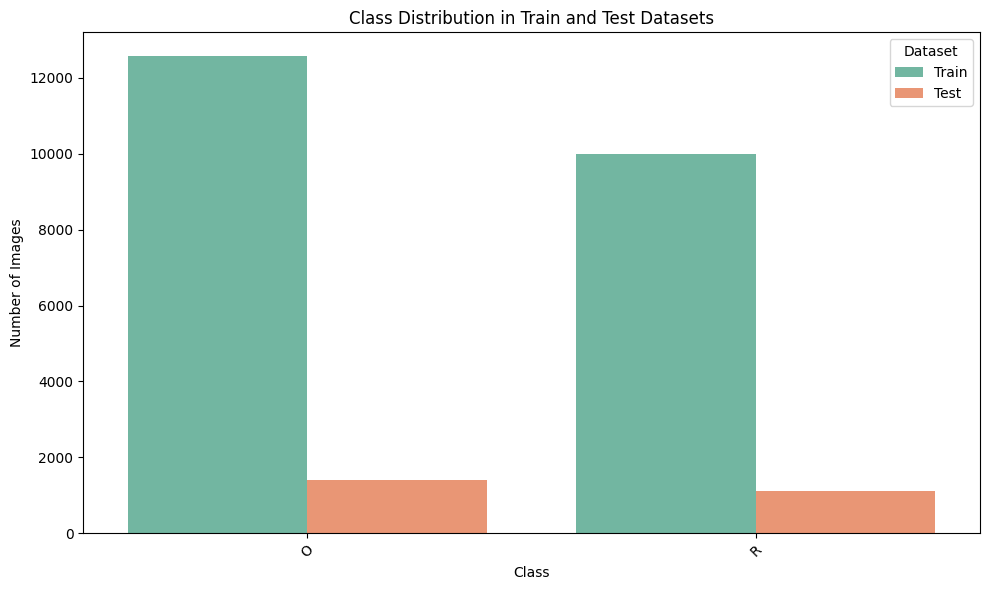

In [11]:
def plot_class_distributions(train_distribution, test_distribution):
    # Data untuk train dan test
    class_names = list(train_distribution.keys())
    train_counts = list(train_distribution.values())
    test_counts = [test_distribution.get(cls, 0) for cls in class_names]

    # Data frame untuk plotting
    data = {
        "Class": class_names * 2,
        "Count": train_counts + test_counts,
        "Dataset": ["Train"] * len(train_counts) + ["Test"] * len(test_counts)
    }

    # Membuat plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=data, x="Class", y="Count", hue="Dataset", palette="Set2")

    # Menambahkan detail ke plot
    plt.title("Class Distribution in Train and Test Datasets")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.legend(title="Dataset")
    plt.tight_layout()

    # Menampilkan plot
    plt.show()

train_distribution = calculate_class_distribution(train_dir)
test_distribution = calculate_class_distribution(test_dir)
plot_class_distributions(train_distribution, test_distribution)

Sample images from class 'O'


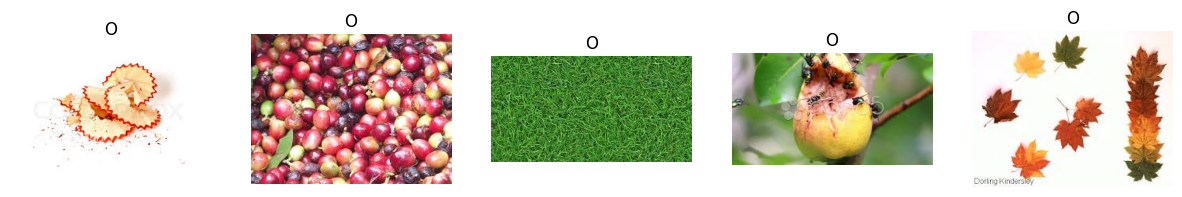

Sample images from class 'R'


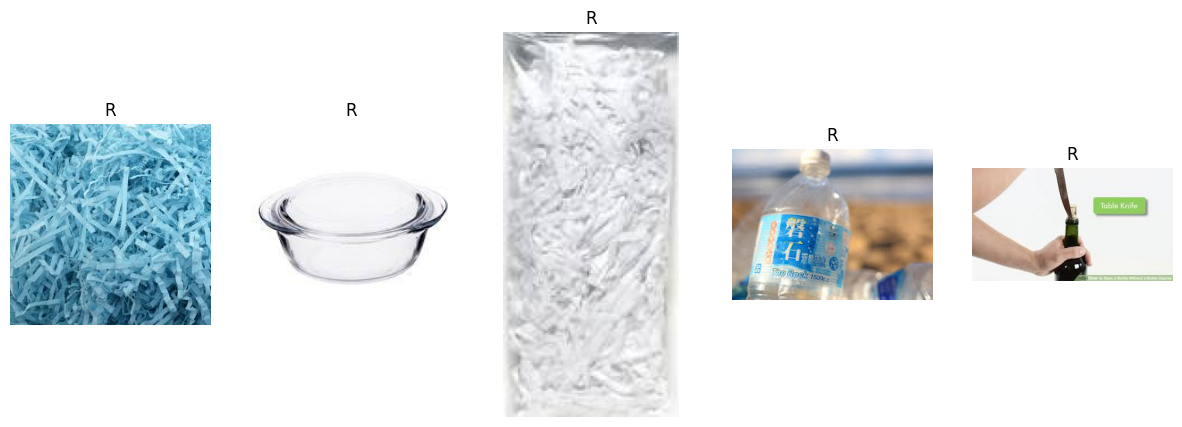

In [12]:
# Visualisasi Sampel Gambar
def visualize_samples(folder_path, class_name, num_samples=5):
    class_folder = os.path.join(folder_path, class_name)
    sample_files = random.sample(os.listdir(class_folder), num_samples)
    plt.figure(figsize=(15, 5))
    for i, file_name in enumerate(sample_files):
        img_path = os.path.join(class_folder, file_name)
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

print("Sample images from class 'O'")
visualize_samples(train_dir, 'O')

print("Sample images from class 'R'")
visualize_samples(train_dir, 'R')

In [13]:
# Preprocessing Data
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='categorical')

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='categorical')

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 22574 files belonging to 2 classes.
Found 2523 files belonging to 2 classes.


In [14]:
# Model Training
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(150, 150, 3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [15]:
model = build_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 3,652,738 (13.93 MB)

 Trainable params: 3,650,818 (13.93 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [17]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 83s 61ms/step - accuracy: 0.7712 - loss: 4.8606 - val_accuracy: 0.8827 - val_loss: 2.6093
Epoch 2/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.8414 - loss: 2.3044 - val_accuracy: 0.9037 - val_loss: 1.2850
Epoch 3/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 55s 48ms/step - accuracy: 0.8553 - loss: 1.1799 - val_accuracy: 0.8744 - val_loss: 0.7042
Epoch 4/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 54s 48ms/step - accuracy: 0.8650 - loss: 0.6447 - val_accuracy: 0.8720 - val_loss: 0.4465
Epoch 5/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 83s 50ms/step - accuracy: 0.8713 - loss: 0.4311 - val_accuracy: 0.8740 - val_loss: 0.3598
Epoch 6/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - accuracy: 0.8825 - loss: 0.3619 - val_accuracy: 0.8843 - val_loss: 0.3199
Epoch 7/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 83s 50ms/step - accuracy: 0.8942 - loss: 0.3213 - val_accuracy: 0.8910 - val_loss: 0.3193
Epoch 8/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 81s 49ms/step - accuracy: 0.9026 -

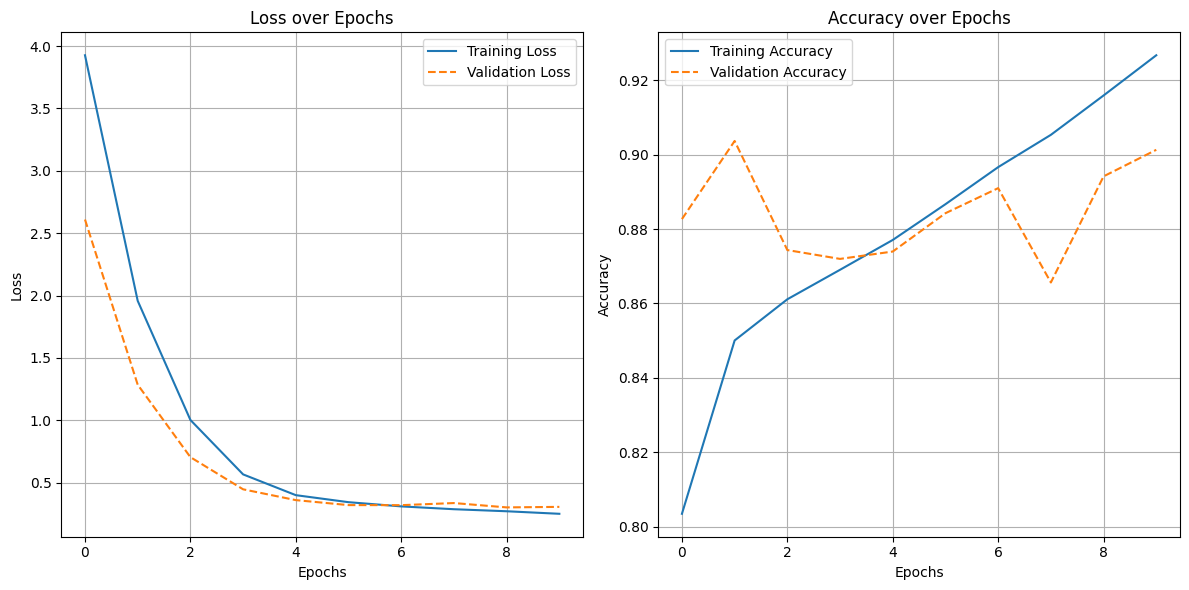

In [18]:
# Loss development plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy development plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show graph
plt.tight_layout()
plt.show()

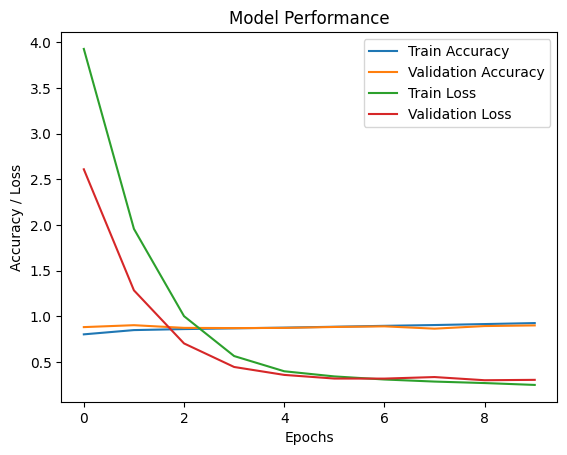

In [19]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.show()

In [20]:
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9044 - loss: 0.3035
Validation Loss: 0.3056679964065552
Validation Accuracy: 0.9013079404830933


In [22]:
model.save("EcoSense_klasifikasi_sampah.h5")
print("Model telah disimpan ke file ecosense_model.h5")

Model telah disimpan ke file ecosense_model.h5


In [23]:
model.save("EcoSense_klasifikasi_sampah.keras")

In [24]:
h5_model_path = 'EcoSense_klasifikasi_sampah.keras'
model = tf.keras.models.load_model(h5_model_path)

# Create a converter from a model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Convert to TFLite format
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_path = 'model.tflite'
with open(tflite_model_path, 'wb') as f:
       f.write(tflite_model)

print(f"Model berhasil dikonversi dan disimpan sebagai {tflite_model_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/tmp/tmpgxjuhyef'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  137298699475984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137298699472144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137298699477328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137298699476176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137298699477520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137298699476944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137298699478672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137298699479824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137298699480208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137298699478480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137298699479056